# **$U^{2}net$ model for Salient Object Detection**
paper: https://arxiv.org/abs/2005.09007

##***Group Members :***

*   **Ninad Mhalgi** -
2018A7TS0162G

*   **Abichal Ghosh** -
2018A7TS0172G

##***GITHUB LINK :***
https://github.com/Ninad1103/DL-Project

# ***Salient Object Detection***
Salient Object Detection(SOD) is a crucial(insert synonym other than essential) problem in Computer Vision(CV) which involves highlighteing the visually salient object regions in images. In simpler words, SOD incloves segmenting the most important and visually attractive(find synonym) objects in images. SOD finds its uses in multiple fields including visual tracking, image segmentation, image captioning, object detection, semantic segmentation, and many more. [ref Salient Object Detection in the Deep Learning Era: An In-depth Survey Wenguan Wang] Further, it has been seen that the recent advances in SOD have been due to introduction of Deep-Learning Based solutions.


# ***Datasets***
The datasets used and considered here are the follows-


1.   **DUTS SOD** 
2.   **MSRA 10K**
3.   **ECSSD**

##**DUTS**
DUTS is the primary dataset which has been used in the paper. Hence, here we start by training the UNet model on this DUTS dataset.

*   **Balanced?** : The DUTS dataset is definitely balanced due to a variety of images ranging from cityscapes, humans, animals, scenes and many more. Further, due to the vast amount of number of images.

*   **Relevance** : As this dataset was used by U2Net paper itself, the relevance is justified.

*   **Limitations** : We have started by training UNet model on this dataset, however in UNet there is a restriction on the size of images due to the structure of the model (i.e with each layer the size of the image keeps decreasing, hence a minimum size is required). Here in DUTS, very few images were present which had a size greater than or equal to this required minimum size. 


##**MSRA 10K**
The MSRA 10K dataset contains over 10k images and their corresponding masks.

**-** ***MSRA 10K Dataset for SOD is the dataset that we used for training UNet and 500 images were used for training U2Net***
*   **Balanced?** : The MSRA 10K dataset is definitely balanced in terms of variety of images ranging from cityscapes, humans, animals, scenes and many more. Further, the MSRA 10K has varying objects of varying sizes, in varying locations meaning there is almost no class imbalance, object scale imbalance and object location imbalance respectively. Hence, this dataset is well balanced.

*   **Relevance** : This is a well known dataset for SOD Training due to the variety of images, salient objects and accurate masks. Due to this reason, this dataset is relevant to the paper.

*   **Limitations** : All the images in MSRA 10K mostly contain only one salient object. Also most of the images have clear salient objects with simple backgrounds. A better and more realistic dataset would be one with more realistic scenes with non salient objects.


##**ECSSD**
**-** ***ECSSD Dataset for SOD is the dataset that we used for training U2Net***

ECSSD has more natural images in its dataset. It has 1000 images which are semantically meaningful but structurally complex images for evaluation. 

# **Downloading the Datasets**

MSRA SELECT: https://drive.google.com/file/d/1xqQI4_rEE2lfCexifYmY6ZkBT_lVvyRw/view?usp=sharing

ECSSD: https://drive.google.com/file/d/1_7gOh6RHco1dOoSWxctVDFSS5NGzZR6e/view?usp=sharing  **(In this notebook, we have used this dataset to train the U$^{2}$net model)**

DUTS: https://drive.google.com/file/d/1_4ejaRNQftBLFSmIE9aPrb7GkMXIOtrI/view?usp=sharing



In [ ]:
#IMPORTING DRIVE
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/

/content/drive/MyDrive


In [ ]:
# TO UNZIP THE DATASET
#!unzip ecssd.zip

In [ ]:
!ls ecssd/

In [ ]:
#PATHS OF TRAIN IMAGES AND MASK 
train_image_path = "ecssd/ecssd_train/images/"
train_mask_path = "ecssd/ecssd_train/masks/"

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image

In [ ]:
import os
import torch
import torchvision
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch.optim as optim
import torchvision.transforms as standard_transforms

import numpy as np
import glob

ecssd/ecssd_train/images/0001.jpg
ecssd/ecssd_train/images/0002.jpg
ecssd/ecssd_train/images/0003.jpg
ecssd/ecssd_train/images/0004.jpg
ecssd/ecssd_train/images/0005.jpg
ecssd/ecssd_train/images/0006.jpg


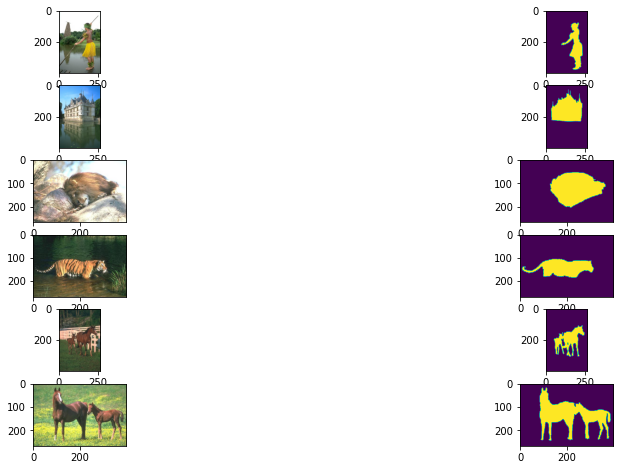

In [ ]:
#CHECKING THE DATASET IMAGES AND CORRESPONDING MASKS
count=0
#enter the number of figures to show
to_show=6
f, axarr = plt.subplots(to_show,2, figsize=(16, 8))

for i in os.listdir(train_image_path):
    db_image=""
    db_mask=""
    db_image=train_image_path+i
    print(db_image)
    #k = "_1stHO"
    db_mask=train_mask_path+i.replace("jpg", "png")
    #print(str)
    img1=Image.open(db_image)
    img2=Image.open(db_mask)
    img2_array = np.array(img2)
    axarr[count, 0].imshow(img1)
    axarr[count, 1].imshow(img2)
    #plt.imshow(img2)
    if(count==to_show-1):
       break
    count+=1

# print(img2_array)

In [ ]:
#EMPTYING THE GPU CACHE
torch.cuda.empty_cache()

In [ ]:
#SETTING THE SEED FOR REPRODUCABILTIY
torch.manual_seed(0)

# **Starting the code for U$^{2}$net**
Built upon the code of Unet with inspiration taken from the official code as given in: https://github.com/xuebinqin/U-2-Net

In [ ]:
class REBNCONV(nn.Module):
    def __init__(self,in_ch=3,out_ch=3,dirate=1):
        super(REBNCONV,self).__init__()

        self.conv_s1 = nn.Conv2d(in_ch,out_ch,3,padding=1*dirate,dilation=1*dirate)
        self.bn_s1 = nn.BatchNorm2d(out_ch)
        self.relu_s1 = nn.ReLU(inplace=True)

    def forward(self,x):

        hx = x
        xout = self.relu_s1(self.bn_s1(self.conv_s1(hx)))

        return xout

In [ ]:
def _upsample_like(src,tar):
    src = F.upsample(src,size=tar.shape[2:],mode='bilinear')
    return src

In [ ]:
#constructing the RSU blocks 

class RSU7(nn.Module):#UNet07DRES(nn.Module):

    def __init__(self, in_ch=3, mid_ch=12, out_ch=3):
        super(RSU7,self).__init__()

        self.rebnconvin = REBNCONV(in_ch,out_ch,dirate=1)

        self.rebnconv1 = REBNCONV(out_ch,mid_ch,dirate=1)
        self.pool1 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.rebnconv2 = REBNCONV(mid_ch,mid_ch,dirate=1)
        self.pool2 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.rebnconv3 = REBNCONV(mid_ch,mid_ch,dirate=1)
        self.pool3 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.rebnconv4 = REBNCONV(mid_ch,mid_ch,dirate=1)
        self.pool4 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.rebnconv5 = REBNCONV(mid_ch,mid_ch,dirate=1)
        self.pool5 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.rebnconv6 = REBNCONV(mid_ch,mid_ch,dirate=1)

        self.rebnconv7 = REBNCONV(mid_ch,mid_ch,dirate=2)

        self.rebnconv6d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv5d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv4d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv3d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv2d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv1d = REBNCONV(mid_ch*2,out_ch,dirate=1)

    def forward(self,x):

        hx = x
        hxin = self.rebnconvin(hx)

        hx1 = self.rebnconv1(hxin)
        hx = self.pool1(hx1)

        hx2 = self.rebnconv2(hx)
        hx = self.pool2(hx2)

        hx3 = self.rebnconv3(hx)
        hx = self.pool3(hx3)

        hx4 = self.rebnconv4(hx)
        hx = self.pool4(hx4)

        hx5 = self.rebnconv5(hx)
        hx = self.pool5(hx5)

        hx6 = self.rebnconv6(hx)

        hx7 = self.rebnconv7(hx6)

        hx6d =  self.rebnconv6d(torch.cat((hx7,hx6),1))
        hx6dup = _upsample_like(hx6d,hx5)

        hx5d =  self.rebnconv5d(torch.cat((hx6dup,hx5),1))
        hx5dup = _upsample_like(hx5d,hx4)

        hx4d = self.rebnconv4d(torch.cat((hx5dup,hx4),1))
        hx4dup = _upsample_like(hx4d,hx3)

        hx3d = self.rebnconv3d(torch.cat((hx4dup,hx3),1))
        hx3dup = _upsample_like(hx3d,hx2)

        hx2d = self.rebnconv2d(torch.cat((hx3dup,hx2),1))
        hx2dup = _upsample_like(hx2d,hx1)

        hx1d = self.rebnconv1d(torch.cat((hx2dup,hx1),1))

        return hx1d + hxin

### RSU-6 ###
class RSU6(nn.Module):#UNet06DRES(nn.Module):

    def __init__(self, in_ch=3, mid_ch=12, out_ch=3):
        super(RSU6,self).__init__()

        self.rebnconvin = REBNCONV(in_ch,out_ch,dirate=1)

        self.rebnconv1 = REBNCONV(out_ch,mid_ch,dirate=1)
        self.pool1 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.rebnconv2 = REBNCONV(mid_ch,mid_ch,dirate=1)
        self.pool2 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.rebnconv3 = REBNCONV(mid_ch,mid_ch,dirate=1)
        self.pool3 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.rebnconv4 = REBNCONV(mid_ch,mid_ch,dirate=1)
        self.pool4 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.rebnconv5 = REBNCONV(mid_ch,mid_ch,dirate=1)

        self.rebnconv6 = REBNCONV(mid_ch,mid_ch,dirate=2)

        self.rebnconv5d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv4d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv3d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv2d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv1d = REBNCONV(mid_ch*2,out_ch,dirate=1)

    def forward(self,x):

        hx = x

        hxin = self.rebnconvin(hx)

        hx1 = self.rebnconv1(hxin)
        hx = self.pool1(hx1)

        hx2 = self.rebnconv2(hx)
        hx = self.pool2(hx2)

        hx3 = self.rebnconv3(hx)
        hx = self.pool3(hx3)

        hx4 = self.rebnconv4(hx)
        hx = self.pool4(hx4)

        hx5 = self.rebnconv5(hx)

        hx6 = self.rebnconv6(hx5)


        hx5d =  self.rebnconv5d(torch.cat((hx6,hx5),1))
        hx5dup = _upsample_like(hx5d,hx4)

        hx4d = self.rebnconv4d(torch.cat((hx5dup,hx4),1))
        hx4dup = _upsample_like(hx4d,hx3)

        hx3d = self.rebnconv3d(torch.cat((hx4dup,hx3),1))
        hx3dup = _upsample_like(hx3d,hx2)

        hx2d = self.rebnconv2d(torch.cat((hx3dup,hx2),1))
        hx2dup = _upsample_like(hx2d,hx1)

        hx1d = self.rebnconv1d(torch.cat((hx2dup,hx1),1))

        return hx1d + hxin

### RSU-5 ###
class RSU5(nn.Module):#UNet05DRES(nn.Module):

    def __init__(self, in_ch=3, mid_ch=12, out_ch=3):
        super(RSU5,self).__init__()

        self.rebnconvin = REBNCONV(in_ch,out_ch,dirate=1)

        self.rebnconv1 = REBNCONV(out_ch,mid_ch,dirate=1)
        self.pool1 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.rebnconv2 = REBNCONV(mid_ch,mid_ch,dirate=1)
        self.pool2 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.rebnconv3 = REBNCONV(mid_ch,mid_ch,dirate=1)
        self.pool3 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.rebnconv4 = REBNCONV(mid_ch,mid_ch,dirate=1)

        self.rebnconv5 = REBNCONV(mid_ch,mid_ch,dirate=2)

        self.rebnconv4d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv3d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv2d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv1d = REBNCONV(mid_ch*2,out_ch,dirate=1)

    def forward(self,x):

        hx = x

        hxin = self.rebnconvin(hx)

        hx1 = self.rebnconv1(hxin)
        hx = self.pool1(hx1)

        hx2 = self.rebnconv2(hx)
        hx = self.pool2(hx2)

        hx3 = self.rebnconv3(hx)
        hx = self.pool3(hx3)

        hx4 = self.rebnconv4(hx)

        hx5 = self.rebnconv5(hx4)

        hx4d = self.rebnconv4d(torch.cat((hx5,hx4),1))
        hx4dup = _upsample_like(hx4d,hx3)

        hx3d = self.rebnconv3d(torch.cat((hx4dup,hx3),1))
        hx3dup = _upsample_like(hx3d,hx2)

        hx2d = self.rebnconv2d(torch.cat((hx3dup,hx2),1))
        hx2dup = _upsample_like(hx2d,hx1)

        hx1d = self.rebnconv1d(torch.cat((hx2dup,hx1),1))

        return hx1d + hxin

### RSU-4 ###
class RSU4(nn.Module):#UNet04DRES(nn.Module):

    def __init__(self, in_ch=3, mid_ch=12, out_ch=3):
        super(RSU4,self).__init__()

        self.rebnconvin = REBNCONV(in_ch,out_ch,dirate=1)

        self.rebnconv1 = REBNCONV(out_ch,mid_ch,dirate=1)
        self.pool1 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.rebnconv2 = REBNCONV(mid_ch,mid_ch,dirate=1)
        self.pool2 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.rebnconv3 = REBNCONV(mid_ch,mid_ch,dirate=1)

        self.rebnconv4 = REBNCONV(mid_ch,mid_ch,dirate=2)

        self.rebnconv3d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv2d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv1d = REBNCONV(mid_ch*2,out_ch,dirate=1)

    def forward(self,x):

        hx = x

        hxin = self.rebnconvin(hx)

        hx1 = self.rebnconv1(hxin)
        hx = self.pool1(hx1)

        hx2 = self.rebnconv2(hx)
        hx = self.pool2(hx2)

        hx3 = self.rebnconv3(hx)

        hx4 = self.rebnconv4(hx3)

        hx3d = self.rebnconv3d(torch.cat((hx4,hx3),1))
        hx3dup = _upsample_like(hx3d,hx2)

        hx2d = self.rebnconv2d(torch.cat((hx3dup,hx2),1))
        hx2dup = _upsample_like(hx2d,hx1)

        hx1d = self.rebnconv1d(torch.cat((hx2dup,hx1),1))

        return hx1d + hxin

### RSU-4F ###
class RSU4F(nn.Module):#UNet04FRES(nn.Module):

    def __init__(self, in_ch=3, mid_ch=12, out_ch=3):
        super(RSU4F,self).__init__()

        self.rebnconvin = REBNCONV(in_ch,out_ch,dirate=1)

        self.rebnconv1 = REBNCONV(out_ch,mid_ch,dirate=1)
        self.rebnconv2 = REBNCONV(mid_ch,mid_ch,dirate=2)
        self.rebnconv3 = REBNCONV(mid_ch,mid_ch,dirate=4)

        self.rebnconv4 = REBNCONV(mid_ch,mid_ch,dirate=8)

        self.rebnconv3d = REBNCONV(mid_ch*2,mid_ch,dirate=4)
        self.rebnconv2d = REBNCONV(mid_ch*2,mid_ch,dirate=2)
        self.rebnconv1d = REBNCONV(mid_ch*2,out_ch,dirate=1)

    def forward(self,x):

        hx = x

        hxin = self.rebnconvin(hx)

        hx1 = self.rebnconv1(hxin)
        hx2 = self.rebnconv2(hx1)
        hx3 = self.rebnconv3(hx2)

        hx4 = self.rebnconv4(hx3)

        hx3d = self.rebnconv3d(torch.cat((hx4,hx3),1))
        hx2d = self.rebnconv2d(torch.cat((hx3d,hx2),1))
        hx1d = self.rebnconv1d(torch.cat((hx2d,hx1),1))

        return hx1d + hxin


In [ ]:
#u2net model

class U2NET(nn.Module):

    def __init__(self,in_ch=3,out_ch=1):
        super(U2NET,self).__init__()

        self.stage1 = RSU7(in_ch,32,64)
        self.pool12 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.stage2 = RSU6(64,32,128)
        self.pool23 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.stage3 = RSU5(128,64,256)
        self.pool34 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.stage4 = RSU4(256,128,512)
        self.pool45 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.stage5 = RSU4F(512,256,512)
        self.pool56 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.stage6 = RSU4F(512,256,512)

        # decoder
        self.stage5d = RSU4F(1024,256,512)
        self.stage4d = RSU4(1024,128,256)
        self.stage3d = RSU5(512,64,128)
        self.stage2d = RSU6(256,32,64)
        self.stage1d = RSU7(128,16,64)

        self.side1 = nn.Conv2d(64,out_ch,3,padding=1)
        self.side2 = nn.Conv2d(64,out_ch,3,padding=1)
        self.side3 = nn.Conv2d(128,out_ch,3,padding=1)
        self.side4 = nn.Conv2d(256,out_ch,3,padding=1)
        self.side5 = nn.Conv2d(512,out_ch,3,padding=1)
        self.side6 = nn.Conv2d(512,out_ch,3,padding=1)

        self.outconv = nn.Conv2d(6*out_ch,out_ch,1)

    def forward(self,x):

        hx = x

        #stage 1
        hx1 = self.stage1(hx)
        hx = self.pool12(hx1)

        #stage 2
        hx2 = self.stage2(hx)
        hx = self.pool23(hx2)

        #stage 3
        hx3 = self.stage3(hx)
        hx = self.pool34(hx3)

        #stage 4
        hx4 = self.stage4(hx)
        hx = self.pool45(hx4)

        #stage 5
        hx5 = self.stage5(hx)
        hx = self.pool56(hx5)

        #stage 6
        hx6 = self.stage6(hx)
        hx6up = _upsample_like(hx6,hx5)

        #-------------------- decoder --------------------
        hx5d = self.stage5d(torch.cat((hx6up,hx5),1))
        hx5dup = _upsample_like(hx5d,hx4)

        hx4d = self.stage4d(torch.cat((hx5dup,hx4),1))
        hx4dup = _upsample_like(hx4d,hx3)

        hx3d = self.stage3d(torch.cat((hx4dup,hx3),1))
        hx3dup = _upsample_like(hx3d,hx2)

        hx2d = self.stage2d(torch.cat((hx3dup,hx2),1))
        hx2dup = _upsample_like(hx2d,hx1)

        hx1d = self.stage1d(torch.cat((hx2dup,hx1),1))


        #side output
        d1 = self.side1(hx1d)

        d2 = self.side2(hx2d)
        d2 = _upsample_like(d2,d1)

        d3 = self.side3(hx3d)
        d3 = _upsample_like(d3,d1)

        d4 = self.side4(hx4d)
        d4 = _upsample_like(d4,d1)

        d5 = self.side5(hx5d)
        d5 = _upsample_like(d5,d1)

        d6 = self.side6(hx6)
        d6 = _upsample_like(d6,d1)

        d0 = self.outconv(torch.cat((d1,d2,d3,d4,d5,d6),1))

        return F.sigmoid(d0), F.sigmoid(d1), F.sigmoid(d2), F.sigmoid(d3), F.sigmoid(d4), F.sigmoid(d5), F.sigmoid(d6)

# **Loss, Training, and Validation**
Here onwards we have customized the validation loss to match with our previous work on UNet. 

**Following which, we have calculated the validation on the ECSSD(and others for the other cases), using our own methods.**

In [ ]:
#loss function
bce_loss = nn.BCELoss(size_average=True)

def muti_bce_loss_fusion(d0, d1, d2, d3, d4, d5, d6, labels_v):

	loss0 = bce_loss(d0,labels_v)
	loss1 = bce_loss(d1,labels_v)
	loss2 = bce_loss(d2,labels_v)
	loss3 = bce_loss(d3,labels_v)
	loss4 = bce_loss(d4,labels_v)
	loss5 = bce_loss(d5,labels_v)
	loss6 = bce_loss(d6,labels_v)

	loss = loss0 + loss1 + loss2 + loss3 + loss4 + loss5 + loss6
	print("l0: %3f, l1: %3f, l2: %3f, l3: %3f, l4: %3f, l5: %3f, l6: %3f\n"%(loss0.data.item(),loss1.data.item(),loss2.data.item(),loss3.data.item(),loss4.data.item(),loss5.data.item(),loss6.data.item()))

	return loss0, loss

/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


In [ ]:
#loss for validation
bce_loss = nn.BCEWithLogitsLoss(size_average=True)

def val_bce_loss(d0, labels_v):
    loss0 = bce_loss(d0, labels_v)

    return loss0.data.item()

/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


In [ ]:
epoch_num = 15
val_num = 0

In [ ]:
model = U2NET(3,1)

These hyperparameters are the only ones which have been used in order to have a single base for comparison.

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=0.00065)

In [ ]:
#TRAINING INITIALIZATION AND DIRECTORIES/DATASETS/DATALOADERS
training_img_name_list = []
training_mask_name_list = []
count = 0

for i in os.listdir(train_image_path):
    duts_image=""
    duts_mask=""
    duts_image=train_image_path+i
    duts_mask=train_mask_path+i.replace("jpg", "png")
    training_img_name_list.append(duts_image)
    training_mask_name_list.append(duts_mask)
    count+=1
    #if(count == 799):
    #  break

train_num = len(training_img_name_list)

In [ ]:
ite_num = 0
running_loss = 0.0
running_tar_loss = 0.0
ite_num4val = 0
save_frq = 2000 

# Training

In [ ]:
if torch.cuda.is_available():
    device = "cuda:0"
    model = model.cuda()

loss_list = [] #to plot the loss 

for epoch in range(epoch_num):
    ite_num4val+=1
    model.train()
    running_loss = 0.0
    running_tar_loss = 0.0
    train_loss = 0
    epoch_steps = 0
    count=0
    for i in range(len(training_img_name_list)):
        input_name = training_img_name_list[i]
        label_name = training_mask_name_list[i]
        
        input_img = Image.open(input_name)
        label_img = Image.open(label_name)

        image_to_tensor = torchvision.transforms.ToTensor()
        
        inputs = image_to_tensor(input_img)
        labels = image_to_tensor(label_img)

        inputs = inputs.reshape((1, inputs.shape[0], inputs.shape[1], inputs.shape[2]))
        labels = labels.reshape((1, labels.shape[0], labels.shape[1], labels.shape[2]))
        
        inputs = inputs.type(torch.FloatTensor)
        labels = labels.type(torch.FloatTensor)

        if torch.cuda.is_available():
            inputs_v, labels_v = Variable(inputs.cuda(), requires_grad = False), Variable(labels.cuda(), requires_grad = False)
        else:
            inputs_v, labels_v = Variable(inputs, requires_grad = False), Variable(labels, requires_grad = False)

        #zero the parameter gradients
        optimizer.zero_grad()  

        #forward + backward + optimize
        #outputs = model(inputs_v)

        #resize_size = (labels_v.shape[2], labels_v.shape[3])
        #outputs_changed = F.interpolate(outputs, size=resize_size, mode="area")
        # loss = loss_fn(outputs_changed, labels_v)
        # loss.backward()
        # optimizer.step()

        # #print stats
        # running_loss+=loss.item()
        # train_loss+=loss.item()
        # epoch_steps+=1
        d0, d1, d2, d3, d4, d5, d6 = model(inputs_v)
        loss2, loss = muti_bce_loss_fusion(d0, d1, d2, d3, d4, d5, d6, labels_v)

        loss.backward()
        optimizer.step()

        # # print statistics
        running_loss += loss.data.item()
        running_tar_loss += loss2.data.item()

            # del temporary outputs and loss
        del d0, d1, d2, d3, d4, d5, d6, loss2, loss

        #print("[epoch: %3d/%3d, batch: %5d, ite: %f] train loss: %3f, tar: %3f " % (epoch + 1, epoch_num, train_num, ite_num, running_loss / ite_num4val, running_tar_loss / ite_num4val),input_name)
        # print("epoch: %")
        epoch_steps+=1

        print("[epoch: %d, epoch step: %4d] loss: %.3f" % (epoch+1, i+1, running_tar_loss/(epoch_steps)))
        
        print(running_tar_loss/(epoch_steps))
        loss_list.append(running_tar_loss/(epoch_steps))
        count+=1
        # if(count==500):
        #     break

        # if(i%1==0):
        #     print("[%d, %5d] loss: %.3f" % (epoch+1, i+1, running_loss/epoch_steps))
        #     loss_list.append(running_loss/epoch_steps)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3704: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


l0: 0.846513, l1: 0.889101, l2: 0.815298, l3: 0.914755, l4: 0.851700, l5: 0.820688, l6: 0.875332

[epoch: 1, epoch step:    1] loss: 0.847
0.846513032913208
l0: 0.924856, l1: 0.886621, l2: 0.777789, l3: 0.854158, l4: 0.754060, l5: 0.752470, l6: 0.783582

[epoch: 1, epoch step:    2] loss: 0.886
0.8856843411922455
l0: 0.765253, l1: 0.665385, l2: 0.656556, l3: 0.647196, l4: 0.651168, l5: 0.671257, l6: 0.675306

[epoch: 1, epoch step:    3] loss: 0.846
0.8455405632654825
l0: 0.918973, l1: 0.830059, l2: 0.748904, l3: 0.780931, l4: 0.706445, l5: 0.682625, l6: 0.718358

[epoch: 1, epoch step:    4] loss: 0.864
0.8638986051082611
l0: 0.788802, l1: 0.715494, l2: 0.719694, l3: 0.733760, l4: 0.719008, l5: 0.724544, l6: 0.706482

[epoch: 1, epoch step:    5] loss: 0.849
0.8488792061805726
l0: 0.740584, l1: 0.641675, l2: 0.643909, l3: 0.661162, l4: 0.660753, l5: 0.695546, l6: 0.696024

[epoch: 1, epoch step:    6] loss: 0.831
0.8308299283186594
l0: 0.758129, l1: 0.746147, l2: 0.709076, l3: 0.71497

In [ ]:
#PLOTTING THE LOSS 
plt.plot(loss_list)

In [ ]:
#SAVE THE TRAINED MODEL
#torch.save(model.state_dict(), "modelu2netmsralr000065e15.pth")

# **Loading the models which have been tarined for Validation**

We have trained our models for our experiments on 2 datasets, one of which is shown here which is ECSSD. The other dataset used is MSRA-Select.

All the various combinations of the trained models have been validated with all 3 datasets.

In order to work with the either of the 2 trained models the pth files are as follows:

ECSSD: https://drive.google.com/file/d/1-W-e2yIEgjaco5z63jbowXUou4cMshYk/view?usp=sharing

MSRA: https://drive.google.com/file/d/1GMPovhImlF7kG9qhO4p1rYysEUERLOlY/view?usp=sharing

In [ ]:
model = U2NET()
if torch.cuda.is_available():
    device = "cuda:0"
    model = model.cuda()

model.load_state_dict(torch.load("modelecssdlr000065e15.pth"))

<All keys matched successfully>

# **Validation path**

Here the path for ECSSD has been used. Can be substituted with either of MSRA-Select and DUTS to get other values.

The validation path for each dataset is as follows - 

**ECSSD -**

val_image_path = "ecssd/ecssd_val/images/"

val_mask_path = "ecssd/ecssd_val/masks/"

**MSRA-SELECT -**

val_image_path = "MSRA_Imgs_GT_select/Image_Val/"

val_mask_path = "MSRA_Imgs_GT_select/Mask_Val/"

**DUTS -**

val_image_path = "DUTS_Resized/DUTS-Image/"

val_mask_path = "DUTS_Resized/DUTS-Mask/"

In [ ]:
val_image_path = "ecssd/ecssd_val/images/"
val_mask_path = "ecssd/ecssd_val/masks/"

In [ ]:
torch.cuda.empty_cache()

Validation predicted images

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3704: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


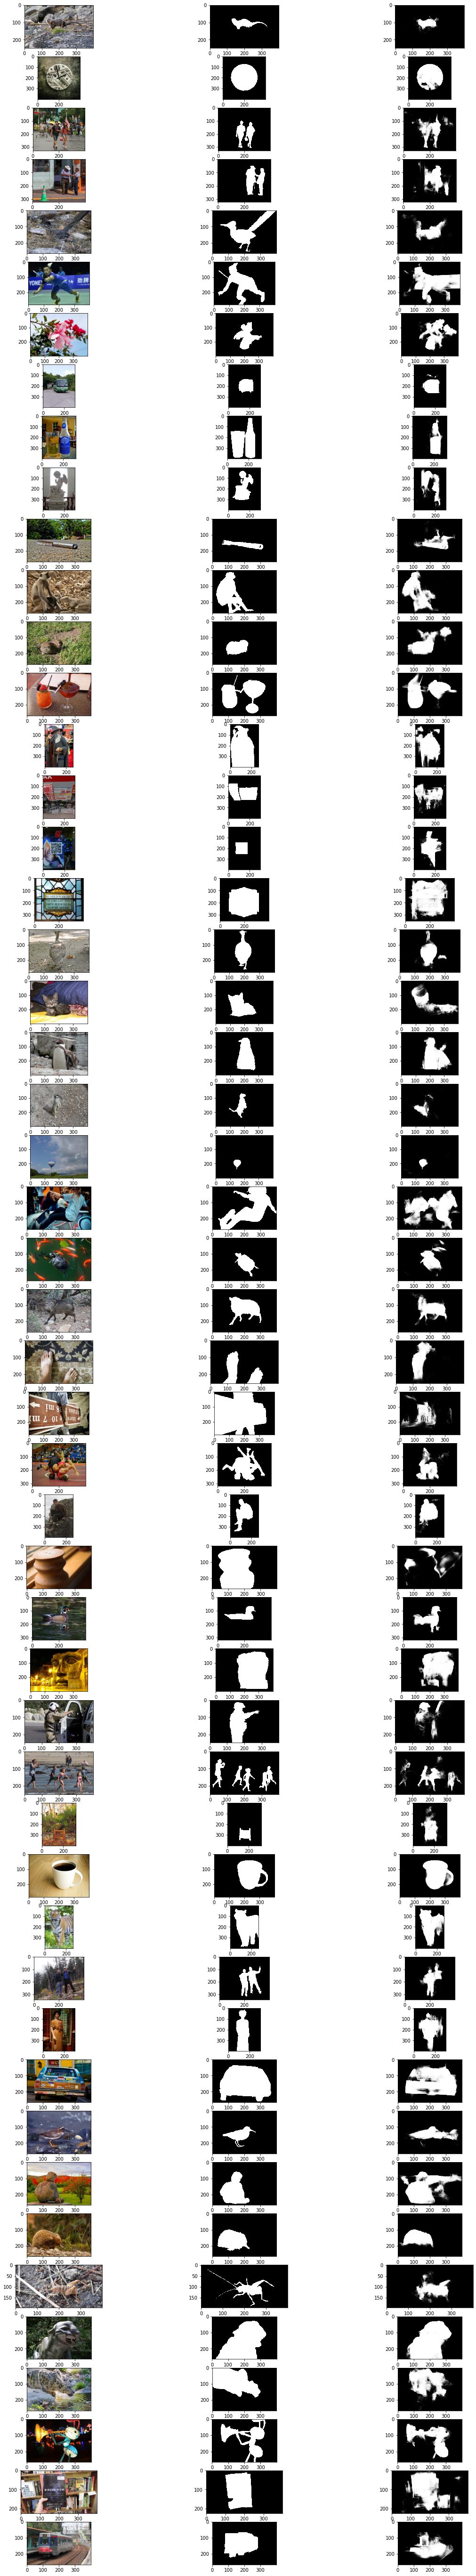

In [ ]:
#Validation
if torch.cuda.is_available():
    device = "cuda:0"
    model = model.cuda()

count_img = 0
count = 0
to_show=50
f, axarr = plt.subplots(to_show, 3, figsize=(20, 100))
step = 0
val_loss_list = []
val_loss = 0
for i in os.listdir(val_image_path):
    torch.cuda.empty_cache()
    duts_image=""
    duts_mask=""
    duts_image=val_image_path+i
    duts_mask=val_mask_path+i.replace("jpg", "png")
    img1=Image.open(duts_image)
    img2=Image.open(duts_mask)
    step+=1

    image_to_tensor = torchvision.transforms.ToTensor()
        
    inputs = image_to_tensor(img1)
    labels = image_to_tensor(img2)

    inputs = inputs.reshape((1, inputs.shape[0], inputs.shape[1], inputs.shape[2]))
    labels = labels.reshape((1, labels.shape[0], labels.shape[1], labels.shape[2]))

    inputs = inputs.type(torch.FloatTensor)
    labels = labels.type(torch.FloatTensor)

    if torch.cuda.is_available():
        inputs_v, labels_v = Variable(inputs.cuda(), requires_grad = False), Variable(labels.cuda(), requires_grad = False)
    else:
        inputs_v, labels_v = Variable(inputs, requires_grad = False), Variable(labels, requires_grad = False)

    #outputs = model(inputs_v)[0].cpu().detach().numpy()
    # d0, d1, d2, d3, d4, d5, d6 = model(inputs_v)
    # loss2, loss = muti_bce_loss_fusion(d0, d1, d2, d3, d4, d5, d6, labels_v)
    outputs = model(inputs_v)[0]
    outputs1 = outputs.cpu().detach().numpy()
    loss2 = val_bce_loss(outputs, labels_v)
    val_loss=loss2
    #print(val_loss)
    val_loss_list.append(val_loss)

    del outputs

    # del d0, d1, d2, d3, d4, d5, d6, loss2, loss

    #resize_size = (outputs.shape[2], outputs.shape[3])
    #labels_changed = F.interpolate(labels_v, size=resize_size, mode="nearest")

    #outputs1 = outputs[0].reshape((outputs.shape[2],outputs.shape[3])) 
    #outputs2 = outputs1.cpu()

    #TO SHOW THE OUTPUTS A FEW APPROXIMATIONS HAVE BEEN MADE FOR BETTER VISUALIZATION
    #FIRST THE OUTPUT IS PASSED THROUGH SIGMOID FUNCTION
    #THEN THE VALUES ABOVE 0.5 ARE TAKEN AS 1 AND BELOW 0.5 ARE TAKEN AS  0

    #outputs2 = torch.sigmoid(outputs1)
    #outputs2 = (outputs2>0.5).float()

    #outputs3 = outputs2.detach().numpy()
    
    outputs_changed = outputs1.reshape((outputs1.shape[2],outputs1.shape[3]))

    labels_v = labels_v.reshape((labels_v.shape[2],labels_v.shape[3])) 
    labels_changed = labels_v.cpu()

    labels_changed_1 = labels_changed.detach().numpy()

    axarr[count, 0].imshow(img1)
    axarr[count, 1].imshow(labels_changed_1, cmap="gray", interpolation='nearest')
    axarr[count, 2].imshow(outputs_changed, cmap="gray", interpolation='nearest')
    count+=1
    if(count==to_show):
        break

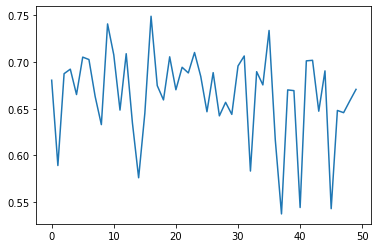

In [ ]:
plt.plot(val_loss_list)

In [ ]:
print("AVERAGE VALIDATION LOSS IS ")
print(sum(val_loss_list)/len(val_loss_list))

AVERAGE VALIDATION LOSS IS 
0.6644891130924225
